<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_precip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created August, 2024

Purpose: Calculates precipitation for each Reach within Mason Drainage from Daymet.

##  DAYMET - doesn't have current data up through 2024 . . . only has until the end of 2023

## 1. Install packages and connect to Google Drive

In [113]:
# -----------------------------#
#   Installs Geemap Package
# -----------------------------#

import subprocess
!pip install geemap

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

# Authenticates and initializes Earth Engine
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project = 'extract-gridmet')

In [114]:
# ----------------------------------------#
#   Import Libraries & Connect to Drive   #
# ----------------------------------------#


!pip install geopandas
import geopandas as gpd #import independent shapefile
import json #for metadata of shapefile
import os #for file paths
import numpy as np #for stats and arrays
import pandas as pd #for dataframes
!pip install pycrs
import pycrs

#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Import reach shapefiles and start/end dates to clip to dataset ##

In [116]:
## ------------------------------------------------------- ##
##   Import shapefile and start/end dates to clip dataset  ##
## ------------------------------------------------------- ##

# change start and end date here
start_date = '2023-3-1' # format is yyyy-mm-dd --> but exclude 0 from beg of days/months
end_date = '2023-7-1'

# create a df with all dates between start_date and end_date
date_range = pd.date_range(start=start_date, end=end_date)
dates_range = pd.DataFrame(date_range, columns=['Date'])

# import reach shapefiles for Mason Creek
shp_file = '/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Mason Reaches/Purdum Reach/layers/purdum_reach.shp'
reach = emap.shp_to_ee(shp_file) # converts shapefile to feature in GEE

map = emap.Map(center=(43.6150, -116.2023),zoom=8)
map.addLayer(ee.Image().paint(reach, 0, 2), {})
map.addLayerControl()
map

Map(center=[43.615, -116.2023], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

## 3. Calculate daily reach precip and perform zonal stats

In [118]:
## ------------------------------------ ##
##    DAILY REACH PRECIPITATION         ##
## ------------------------------------ ##

dates_list = dates_range['Date'].dt.strftime('%Y-%m-%d').tolist()  # Convert dates to a list of strings

precip = []

for i in dates_list:
    date = ee.Date(i)
    daymet = ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate(date, date.advance(1, 'day'))
    daily_sum = daymet.select('prcp').map(lambda image: image.clip(reach).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=reach,
        scale=1000,
        bestEffort=True
    ).set('system:time_start', image.get('system:time_start')))
    precip.append(daily_sum)

pr = ee.ImageCollection.fromImages(precip)

In [119]:
## ------------------------ ##
##   CALCULATE ZONAL STATS  ##
## ------------------------ ##

out_stats = os.path.join('/content/drive/MyDrive/Data/Mason/data_output/precip_out/precip_purdum.csv')
emap.zonal_statistics(pr, reach, out_stats, statistics_type='SUM', scale=1000)

Computing statistics ...


Exception: Collection.map: A mapped algorithm must return a Feature or Image.

In [ ]:
## ------------------------------------------------ ##
##   CREATE CLIMATE STAT FOR EACH REACH AND EXPORT  ##
## ------------------------------------------------ ##

# delete excess and make for each reach

date = np.arange(dates_range)
precip = pd.read_csv('.csv')

names = reach['Name']

for i in range(len(names)):
  df = pd.DataFrame(date, columns=['Date'])
  df['NAME'] = names[i]
  df['prcp'] = precip.iloc[i,0:34].values
  out_path = os.path.join('.csv')
  df.to_csv(out_path)

## Using coordinates instead of shapefile

In [56]:
import sys
sys.path.append(r"..")
! pip install daymetpy
import daymetpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
# Load Solomon Reach
reach = gpd.read_file('/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Mason Reaches/Solomon Reach/solomon_reach_point.shp')

# Print the coordinates of the points
for index, row in reach.iterrows():
    point = row['geometry']
    print(f"Coordinates for point {index}: {point.x}, {point.y}")

Coordinates for point 0: -116.644136027597, 43.67290606050114


In [97]:
ornl_lat, ornl_long = 43.67290606050114, -116.644136027597
df = daymetpy.daymet_timeseries(lon=ornl_long, lat=ornl_lat, start_year=2018, end_year=2023)
df

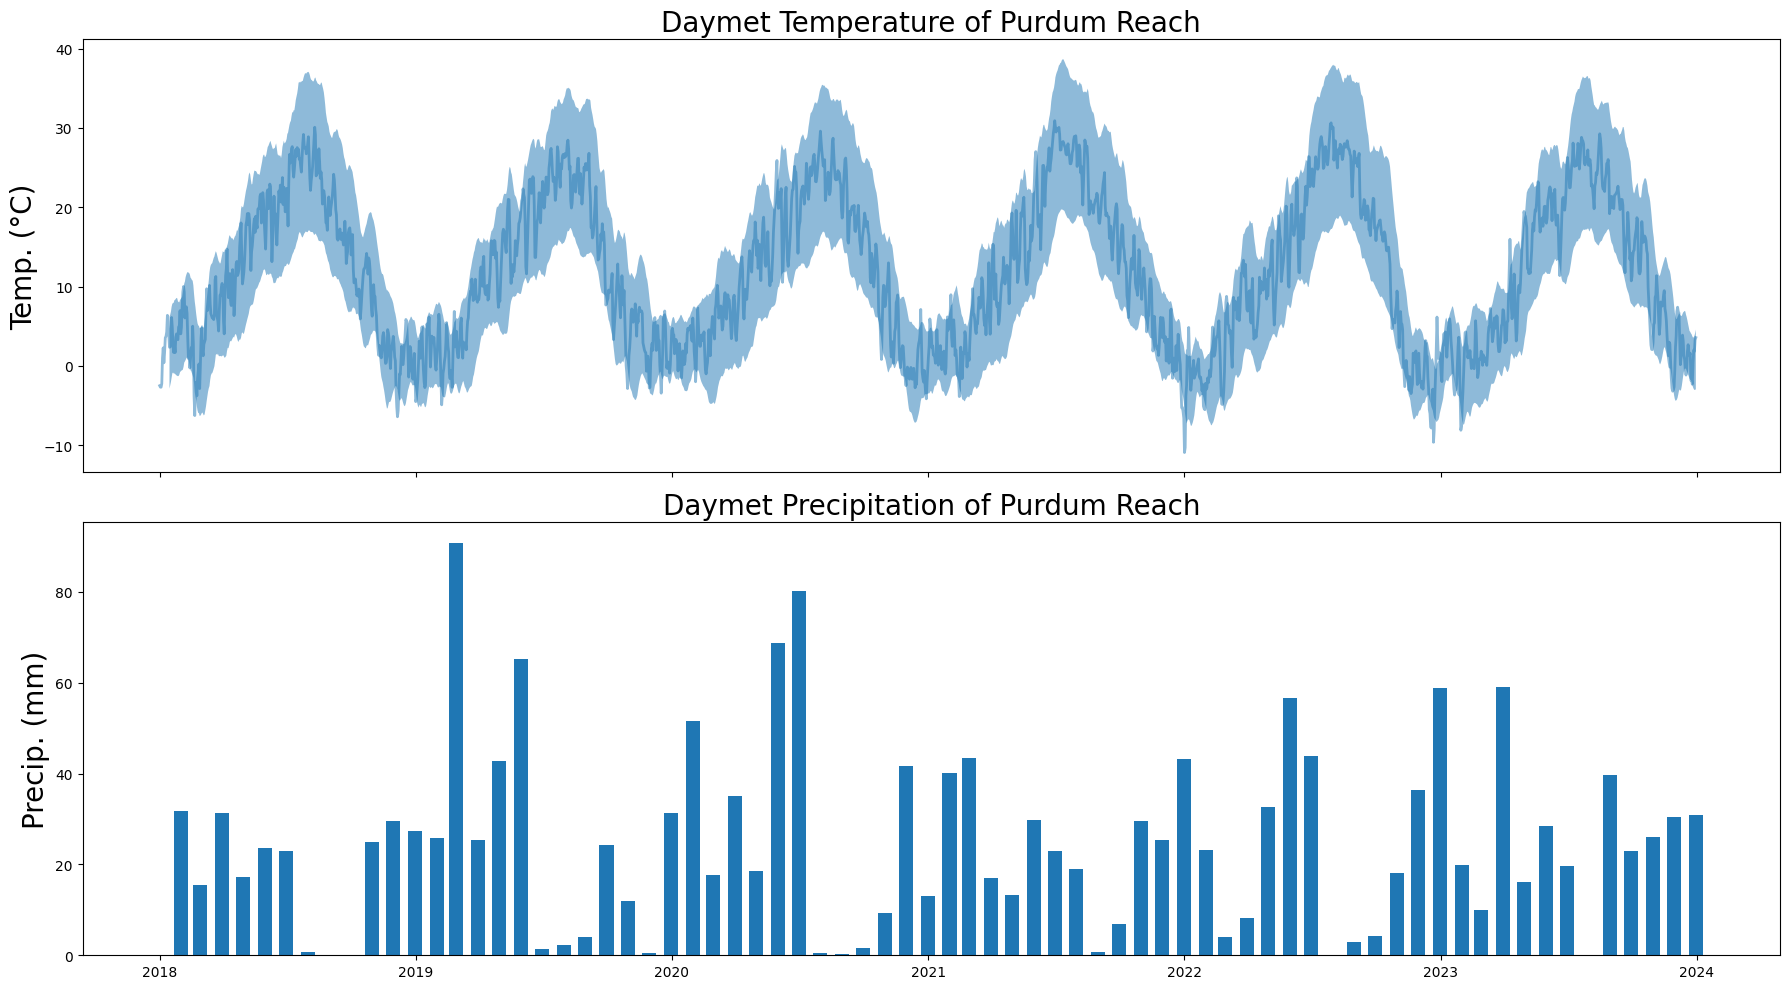

In [99]:
#-----------------#
#   Create Plot   #
#-----------------#

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, figsize=(18, 10), sharex=True)

# Calculate 15-day rolling mean for tmin and tmax
rolling3day = df[['tmin', 'tmax']].rolling(window=15, center=False).mean()

# Plot temperature range and average temperature
ax1.fill_between(rolling3day.index, rolling3day['tmin'], rolling3day['tmax'], alpha=0.5, lw=0)
ax1.plot(df.index, df[['tmax', 'tmin']].mean(axis=1), lw=2, alpha=0.5)
ax1.set_title('Daymet Temperature of Purdum Reach', fontsize=20)
ax1.set_ylabel(u'Temp. (°C)', fontsize=20)

# Resample the precipitation data by month and sum it
monthlysum = df.resample("M").sum()

# Plot monthly precipitation as bars
ax2.bar(monthlysum.index, monthlysum['prcp'], width=20)
ax2.set_title('Daymet Precipitation of Purdum Reach', fontsize=20)
ax2.set_ylabel(u'Precip. (mm)', fontsize=20)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

## ERA 5

In [104]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Load the ERA5 dataset for precipitation
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
    .filterDate('2024-01-01', '2024-12-31') \
    .select('total_precipitation')

# Check available date range
date_range = era5.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
start_date = ee.Date(date_range.get('min')).format('YYYY-MM-dd').getInfo()
end_date = ee.Date(date_range.get('max')).format('YYYY-MM-dd').getInfo()

print(f"ERA5 data is available from {start_date} to {end_date}.")

ERA5 data is available from 2024-01-01 to 2024-08-26.


In [105]:
# change start and end date here
start_date = '2023-3-1' # format is yyyy-mm-dd --> but exclude 0 from beg of days/months
end_date = '2023-7-1'

# create a df with all dates between start_date and end_date
date_range = pd.date_range(start=start_date, end=end_date)
dates_range = pd.DataFrame(date_range, columns=['Date'])

# import reach shapefiles for Mason Creek
shp_file = '/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Mason Reaches/Purdum Reach/layers/purdum_reach.shp'
reach = ee.FeatureCollection(shp_file) # converts shapefile to feature in GEE

In [106]:
# Load ERA5 daily aggregated data
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
    .filterDate('2024-01-01', '2024-12-31') \
    .select('total_precipitation')

# Clip the data to the reach region
era5_clipped = era5.map(lambda image: image.clip(reach))

In [108]:
# Function to calculate daily total precipitation over the reach
def calculate_daily_precip(image):
    total_precip = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=reach.geometry(),
        scale=1000,  # Adjust scale as needed
        bestEffort=True
    )
    return image.set('daily_precip', total_precip)

# Apply the function to each image in the collection
daily_precip = era5_clipped.map(calculate_daily_precip)

In [111]:
# Convert daily_precip to a FeatureCollection for export
daily_precip_fc = daily_precip.map(lambda image: ee.Feature(None, image.toDictionary(['system:time_start', 'daily_precip'])))

# Export the data to a CSV file in your Google Drive
task = ee.batch.Export.table.toDrive(
    collection=daily_precip_fc,
    description='ERA5_Daily_Precipitation_2024',
    fileFormat='CSV',
    fileNamePrefix='precip_purdum',
    folder='Data/Mason/data_output/precip_out'
)

task.start()

print("Exporting daily precipitation data for 2024 to Google Drive at /content/drive/MyDrive/Data/Mason/data_output/precip_out/precip_purdum.csv")

EEException: Collection.loadTable: Collection asset '/content/drive/MyDrive/Data/Mason/data_input/reach_shapefile/Mason Reaches/Purdum Reach/layers/purdum_reach.shp' not found.

## Gridmet

In [121]:
# Load the shapefile as a FeatureCollection
solomon_reach = ee.FeatureCollection("users/your_username/Solomon_reach")  # Adjust the path to your shapefile

In [141]:
# Assuming 'dates_range' is a DataFrame with a 'Date' column containing all dates
dates_list = dates_range['Date'].dt.strftime('%Y-%m-%d').tolist()  # Convert dates to a list of strings

precip = []

# Iterate through each date and retrieve the gridMET precipitation data
for i in dates_list:
    date = ee.Date(i)

    # Filter the gridMET dataset for the specific date
    gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate(date, date.advance(1, 'day'))

    # Calculate the daily precipitation sum for the region
    daily_sum = gridmet.select('pr').map(lambda image: image.clip(reach).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=reach,
        scale=1000,
        bestEffort=True
    ).set('system:time_start', image.get('system:time_start')))

    precip.append(daily_sum)

# Convert the list of daily sums to an ImageCollection
pr = ee.ImageCollection.fromImages(precip)

In [140]:
# Function to convert each image to a feature with date and precipitation value
def image_to_feature(image):
    # Get the date from the image metadata
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')

    # Extract the daily precipitation value
    daily_precip = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=reach.geometry(),
        scale=1000,
        bestEffort=True
    ).get('pr')  # Assuming 'pr' is the band for precipitation in mm

    # Create a feature with date and precipitation as properties
    feature = ee.Feature(None, {
        'date': date,
        'precip_mm': daily_precip
    })

    return feature

# Map the function over the ImageCollection to create a FeatureCollection
features = pr.map(image_to_feature)

# Convert to a FeatureCollection
feature_collection = ee.FeatureCollection(features)

task = ee.batch.Export.table.toDrive(
    collection=feature_collection,
    description='gridMET_Daily_Precipitation_2024',
    fileFormat='CSV',
    fileNamePrefix='precip_solomon_reach',
    folder='/content/drive/MyDrive/Data/Mason/data_output/precip_out'
)
task.start()

print("Exporting daily precipitation data for 2024 to Google Drive folder 'Data/Mason/data_output/precip_out'.")

Exporting daily precipitation data for 2024 to Google Drive folder 'Data/Mason/data_output/precip_out'.
